# sobel算子计算梯度特征
1. 原图转换为梯度图，下一步计算sad代价


In [2]:
#测试块
import numpy as np
import cv2
from sgm_utils import utils
utils.module1()

ModuleNotFoundError: No module named 'utils'

In [13]:
def preProcess(imgPath,preFilterCap=15,dx=1,dy=0,ksize=3):
    '''
    功能：使用sobel算子计算输入图像梯度特征图
    return: 梯度特征图
    input：
        imgPath:输入图像的路径
        dx,dy:==1表示在该方向求梯度，==0该方向不求梯度
        ksize:sobel算子核尺寸
    '''
    img=cv2.imread(imgPath,0) #原始图像
    sobel=cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=3) 
    scaled_sobel = cv2.convertScaleAbs(sobel)  # 转回uint8，梯度图像
    myPreFilterCap(scaled_sobel,preFilterCap)
    return scaled_sobel

def myPreFilterCap(image,preFilterCap):
    '''
    将图像像素值限定在0~preFilterCap范围内
    '''
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]<-preFilterCap: 
                image[i,j]=0
            elif image[i,j]>=-preFilterCap and image[i,j]<=preFilterCap:
                image[i,j]+=preFilterCap
            else:
                image[i,j]=preFilterCap*2      
                
def dispCalcu(left,right,maxDisparity,P1=0,P2=0,ksize=3,filterSize=3):
    '''
    以右图为基准计算3D代价卷（x,y,d)
    input:
        left:左图
        right：右图
        maxDisparity:最大视差
        P1，P2：平滑惩罚
        ksize：sad窗口尺寸
        filterSize:代价卷滤波核尺寸，奇数
    return：3D代价卷（x,y,d)
    '''
    halfKernel=(ksize-1)//2

    #异常检测
    if left.shape!=right.shape:
        raise Exception("左右图像尺寸不相同")
    if ksize%2==0:
        raise Exception("SAD窗口尺寸ksize必须是奇数")
    if filterSize%2==0:
        raise Exception("filterSize必须是奇数")
        
    #padding:左图右侧额外扩展，扩展值为halfKernel+maxDisparity
    leftPadding=cv2.copyMakeBorder(left,halfKernel,halfKernel,halfKernel,halfKernel+maxDisparity,cv2.BORDER_REPLICATE)
    rightPadding=cv2.copyMakeBorder(right,halfKernel,halfKernel,halfKernel,halfKernel,cv2.BORDER_REPLICATE)

    #对于右图图中的每个像素（0，0开始），计算视差d：0~maxDisparity每个视差等级的代价
    #右图向右寻找对应点,对应点的范围是原图，而不是padding后的图
    rows=right.shape[0] #最大行数
    cols=right.shape[1] #最大列数
    costVolume=np.zeros((rows,cols,maxDisparity))
    for i in range(halfKernel,rows):
        for j in range(halfKernel,cols):
            for d in range(maxDisparity): # d:视差
                #因为事先进行了padding，所以不会出现j+d越界的情况
                #左右图切片：(i,j)-halfKernel ~ +halfKernel
                costVolume[i,j,d]=np.sum(np.abs(rightPadding[i-halfKernel:i+halfKernel,j-halfKernel:j+halfKernel]-
                leftPadding[i-halfKernel:i+halfKernel,j+d-halfKernel:j+d+halfKernel])) 
                
    #可选1：横竖两个方向四条路径半全局更新代价卷
    #*可选2：代价卷滤波提高稳定性
    filterSize_half=(filterSize-1)//2
    costPadding=np.pad(costVolume,((filterSize_half,filterSize_half),(filterSize_half,filterSize_half),(filterSize_half,filterSize_half)),'edge')
    costVolumeFilter=np.zeros(costVolume.shape) #视差图
    for i in range(filterSize_half,costVolume.shape[0]):
        for j in range(filterSize_half,costVolume.shape[1]):
            for d in range(filterSize_half,costVolume.shape[2]): # d:视差
                costVolumeFilter[i,j,d]=np.mean(costPadding[i-filterSize_half:i+filterSize_half,j-filterSize_half:j+filterSize_half,d-filterSize_half:d+filterSize_half])
    
    #代价聚合
        #将每个点各个视差等级上的代价归一化到0，1之间，使之成为概率，sum（概率*视差）=该点的最终视差
    disp=np.zeros(costVolumeFilter.shape[0:2]) #视差图
    print(costVolumeFilter.shape[0:2])
    for i in range(costVolumeFilter.shape[0]):
        for j in range(costVolumeFilter.shape[1]):
            costSum=np.sum(costVolumeFilter[i,j,:])
#             print(costSum)
            for d in range(costVolumeFilter.shape[2]): # d:视差
                disp[i,j]+=costVolumeFilter[i,j,d]/(costSum+1)*d
#     disp=disp.astype(np.uint8) 
    return disp #返回的disp是小数数组，还需插值才是uint8灰度图

#next：opencv插值 ，打开参考pdf

#next:左右一致性检测

                    

(278, 322)


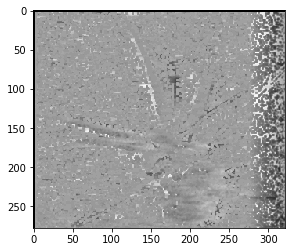

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#参数列表
preFilterCap=15
maxDisparity=50
# img=cv2.imread("girl.jpg",0) #原始图像
left=preProcess("l_view.png") #特征图
right=preProcess("r_view.png")
disp=dispCalcu(left,right,maxDisparity)

# print(disp)

plt.imshow(disp,cmap='gray')
plt.show()


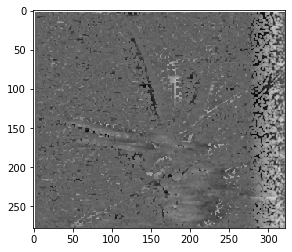

In [18]:
from matplotlib import pyplot as plt

plt.imshow(disp,cmap=plt.cm.gray_r)
plt.show()

In [19]:
disp


array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 26, ..., 27, 26, 26],
       ...,
       [ 0,  0, 25, ..., 11, 17, 18],
       [ 0,  0, 25, ..., 13, 17, 16],
       [ 0,  0, 25, ..., 12, 14, 14]], dtype=uint8)

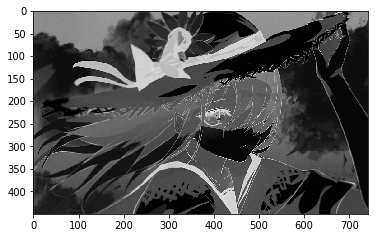

In [17]:
#测试图像显示
import numpy as np
import cv2
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
img=cv2.imread('girl.jpg',0)
plt.imshow(img,cmap=plt.cm.gray_r)
plt.show()

